In [2]:
import pandas as pd 
import numpy as np

In [14]:
df_raw = pd.read_csv('./dataset/bank/bank-full.csv', sep=';')

In [15]:
df = df_raw[['age',
            'job',
            'marital',
            'education',
            'balance',
            'housing',
            'contact',
            'day',
            'month',
            'duration',
            'campaign',
            'pdays',
            'previous',
            'poutcome',
            'y'
            ]]

In [16]:
numeric = ['age',
            'balance',
            'day',
            'duration',
            'campaign',
            'pdays',
            'previous',]

In [17]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,no


In [18]:
y = list(df.y)

y_encoded = []
for e in y:
    y_encoded.append(1 if e == 'yes' else 0)

In [19]:
df_encoded = df.copy()

In [20]:
df_encoded.y = y_encoded

In [21]:
df_X = df_encoded.copy()

In [22]:
df_X = df_X.drop(['y'], axis=1)

In [6]:
from sklearn.model_selection import train_test_split

In [98]:
df_train_val, df_test = train_test_split(df_X, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

In [99]:
y_train_val, y_test = train_test_split(y_encoded, test_size=0.2, random_state=1)
y_train, y_val = train_test_split(y_train_val, test_size=0.25, random_state=1)

## Question 1: ROC AUC feature importance

In [11]:
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

In [31]:

for e in ['balance','day','duration','previous']:
   print(auc(df_train[e], y_train))

ValueError: x is neither increasing nor decreasing : [  40 4790  392 ...  289  312  580].

## Question 2: Training the model

In [32]:
from sklearn.feature_extraction import DictVectorizer

In [33]:
train_dict = df_train[:].to_dict(orient='records')

In [34]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

DictVectorizer(sparse=False)

In [35]:
X_train = dv.transform(train_dict)

In [36]:
from sklearn.linear_model import LogisticRegression

In [37]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [38]:
val_dict = df_val[:].to_dict(orient='records')
X_val = dv.transform(val_dict)

In [39]:
y_pred = model.predict_proba(X_val)[:, 1]

In [43]:
print(roc_auc_score(y_val, y_pred))

0.8999780109216243


## Question 3: Precision and Recall

In [70]:
from sklearn.metrics import precision_score, recall_score

In [74]:
thresholds = np.linspace(0, 1, 101)

p = []
r = []

for t in thresholds:
    pred = y_pred >= t
    p.append(precision_score(y_val, pred))
    r.append(recall_score(y_val, pred))      


/home/ariqhakim/miniconda3/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [76]:
from matplotlib import pyplot as plt
%matplotlib inline

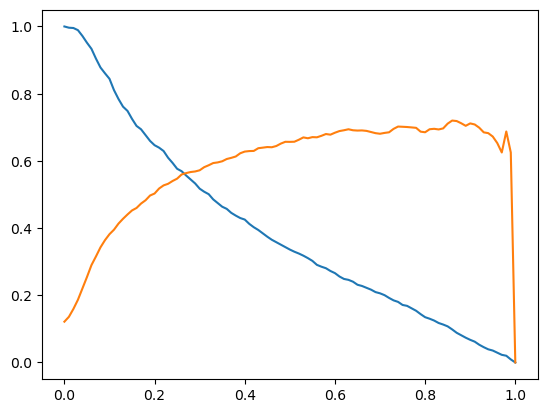

In [79]:
plt.plot(thresholds, r)
plt.plot(thresholds, p)
plt.show()

## Question 4: F1 score

In [80]:
prec = np.array(p)
rec = np.array(r)

In [81]:
f1 = 2 * (prec * rec) / (prec + rec)

/tmp/ipykernel_1469/3855391403.py:1: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * (prec * rec) / (prec + rec)


In [87]:
max_f = f1[0]
idx = 0

for i in range(101):
    if f1[i] > max_f:
        max_f = f1[i]
        idx = i

In [89]:
idx

22

In [90]:
thresholds[22]

0.22

## Question 5: 5-Fold CV

In [106]:
def train(df_train, y_train, C=1.0):
    dicts = df_train.to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [95]:
def predict(df, dv, model):
    dicts = df.to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [94]:
from tqdm.auto import tqdm
from sklearn.model_selection import KFold

In [101]:
df_train_val, df_test = train_test_split(df_encoded.copy(), test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_val, test_size=0.25, random_state=1)

In [114]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_train_val):
    df_train = df_train_val.iloc[train_idx]
    df_val = df_train_val.iloc[val_idx]

    y_train = df_train.y.values
    y_val = df_val.y.values

    dv, model = train(df_train, y_train, C=1)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [111]:
print(np.mean(scores), np.std(scores))

0.9999998960331986 2.0793360264725888e-07


In [116]:
n_splits = 5

for C in tqdm([0.000001, 0.001, 1]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_train_val):
        df_train = df_train_val.iloc[train_idx]
        df_val = df_train_val.iloc[val_idx]

        y_train = df_train.y.values
        y_val = df_val.y.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/3 [00:00<?, ?it/s]

C=1e-06 0.702 +- 0.009
C=0.001 0.987 +- 0.003
C=1 1.000 +- 0.000
